In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context('notebook', font_scale=1.3)
sns.set_palette('tab10')
sns.set_style('white')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
from glob import glob
import json
run = 'cougar'
def rows():
    for fn in glob(f'../julia/runs/{run}/results/rollouts*'):
        with open(fn) as f:
            d = json.load(f)
            for roll in d['rollouts']:
                roll.update(d['params'])
                yield roll
df = pd.DataFrame(rows())
# df.to_pickle(f'data/matched_{run}')
# df = pd.read_pickle(f'data/matched_{run}')

In [24]:
df['n_step'] = df.focused.apply(len)
df_value = np.stack(df.value)
df['value_max'] = df_value.max(1)
df['value_min'] = df_value.min(1)
df['value_mean'] = df_value.mean(1)
df['value_std'] = df_value.std(1)
df['choice_value'] = df_value[np.arange(len(df)), df.choice.values - 1]
cutoff = df.n_step.quantile(0.99)
df = df.query('n_step < @cutoff').copy()
df['loss'] = df.value_max - df.choice_value
df['error'] = df.loss > 0
df['n_fix'] = df.focused.apply(lambda x: np.sum(np.diff(x) != 0) + 1)

import statsmodels.formula.api as smf
def ols(formula):
    return smf.ols(formula, data=df).fit().summary().tables[1]

In [26]:
ols('n_step ~  + value_std')

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,23.6176,0.194,121.559,0.000,23.237,23.998
value_min,0.0239,0.164,0.145,0.884,-0.298,0.345
value_std,-4.6503,0.317,-14.667,0.000,-5.272,-4.029


In [15]:
ols('n_step ~ value_max + value_std')

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,26.1531,0.231,113.331,0.000,25.701,26.605
value_max,-0.0193,0.196,-0.099,0.921,-0.403,0.364
value_std,-6.3329,0.380,-16.687,0.000,-7.077,-5.589


In [27]:
ols('n_step ~ value_mean * switch_cost')

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-1.221e+10,4.54e+12,-0.003,0.998,-8.9e+12,8.88e+12
value_mean,3.053e+04,1.13e+07,0.003,0.998,-2.22e+07,2.23e+07
switch_cost,1.221e+10,4.54e+12,0.003,0.998,-8.88e+12,8.9e+12
value_mean:switch_cost,-3.053e+04,1.13e+07,-0.003,0.998,-2.23e+07,2.22e+07


# Compare parameters

In [6]:
grp = df.groupby(['obs_sigma', 'sample_cost', 'switch_cost', 'seed'])[['n_step', 'reward', 'n_fix', 'choice_value']].mean()

In [ ]:
sns.catplot('obs_sigma', 'choice_value', row='sample_cost', col='switch_cost', data=grp.reset_index())

# Match human plots

In [37]:
hdf = pd.read_pickle('data/human_trials')
cutoff = hdf.rt.quantile(0.99)
hdf = hdf.query('rt < @cutoff')
hdf.rt /= 1000

In [38]:
params = ['obs_sigma', 'sample_cost', 'switch_cost']
for k in params:
    print(k, df[k].unique())

obs_sigma [3. 5. 8.]
sample_cost [0.001 0.002 0.003 0.005 0.01 ]
switch_cost [2. 3. 4. 8.]


In [43]:
MODEL_PARAMS = (5, 0.002, 8)
mdf = df.set_index(params).loc[MODEL_PARAMS]

mdf['n_step'] = mdf.focused.apply(len)
mdf_value = np.stack(mdf.value)
mdf['value_max'] = mdf_value.max(1)
mdf['value_min'] = mdf_value.min(1)
mdf['value_mean'] = mdf_value.mean(1)
mdf['value_std'] = mdf_value.std(1)
mdf['choice_value'] = mdf_value[np.arange(len(mdf)), mdf.choice.values - 1]
cutoff = mdf.n_step.quantile(0.99)
mdf = mdf.query('n_step < @cutoff').copy()
mdf['loss'] = mdf.value_max - mdf.choice_value
mdf['error'] = mdf.loss > 0
mdf['n_fix'] = mdf.focused.apply(lambda x: np.sum(np.diff(x) != 0) + 1)

time_per_step = hdf.rt.mean() / mdf.n_step.mean()
print('seconds per step', time_per_step)
mdf['rt'] = mdf.n_step * time_per_step

seconds per step 0.08267850440661169


In [45]:
hdf['agent'] = 'Human'
mdf['agent'] = 'Model'

for dd in mdf, hdf:
    dd['loss'] = dd.value_max - dd.choice_value
    dd['error'] = dd.loss > 0

tdf = pd.concat([hdf, mdf]).dropna(1)

In [46]:
def plot(func, data=tdf):
    g = sns.FacetGrid(data, col='agent')
    g.map_dataframe(func)
    g.set_titles('{col_name}')
    return g

def save(name):
    plt.tight_layout(pad=1.15)
    plt.savefig(f'figs/{name}.pdf')

/usr/local/lib/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


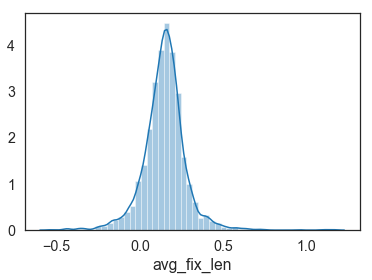

In [70]:
tdf['avg_fix_len'] = np.log(tdf.rt) / tdf.n_fix
sns.distplot(tdf.query('agent == "Human"').avg_fix_len)

/usr/local/lib/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


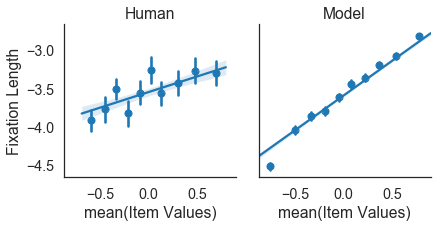

In [96]:
tdf['avg_fix_len'] = np.log(tdf.rt) - tdf.n_fix
def f(data, **kwargs):
    sns.regplot('value_mean', 'avg_fix_len', data=data, x_bins=10,)

plot(f).set_axis_labels('mean(Item Values)', 'Fixation Length')

/usr/local/lib/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


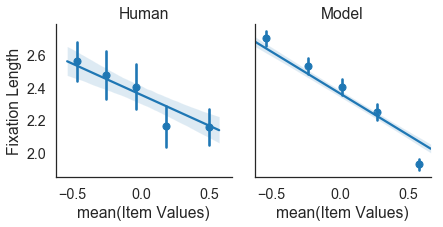

In [88]:
tdf['avg_fix_len'] = tdf.rt
def f(data, **kwargs):
    sns.regplot('value_mean', 'avg_fix_len', data=data, x_bins=5)

plot(f).set_axis_labels('mean(Item Values)', 'Fixation Length')

In [48]:
import statsmodels.formula.api as smf
def ols(formula, data=mdf):
    return smf.ols(formula, data=mdf).fit().summary().tables[1]

ols('n_fix ~ value_mean + n_step')

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.1876,0.010,209.852,0.000,2.167,2.208
value_mean,-0.7305,0.011,-63.643,0.000,-0.753,-0.708
n_step,0.0689,0.000,243.337,0.000,0.068,0.070


In [ ]:
sns.regplot('loss', 'rt', data=mdf, x_bins=10)

In [ ]:
def f(data, **kwargs):
    sns.regplot('loss', 'rt', data=data, scatter=False)
    
plot(f)

## Choice quality

/usr/local/lib/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


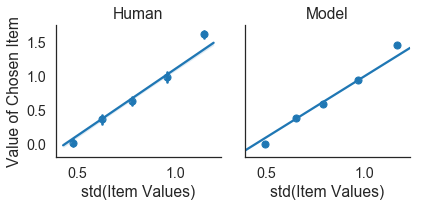

In [234]:
def f(data, **kwargs):    
    sns.regplot('value_std', 'choice_value', data=data, x_bins=5, ci=95)
#     plt.axhline(tdf.rt.mean(), ls='--')
plot(f).set_axis_labels('std(Item Values)', 'Value of Chosen Item')
save('choice_value')

In [ ]:
def f(data, **kwargs):    
    sns.kdeplot(data.value_std, data.choice_value)
#     plt.axhline(tdf.rt.mean(), ls='--')
plot(f).set_axis_labels('std(Item Values)', 'Reaction Time')
save('choice_value')

## Number of fixations

In [ ]:
def n_fix(data, **kwargs):
    vc = data.n_fix.value_counts().sort_index()
    vc /= vc.sum()
    vc = vc.loc[1:10]
    vc.plot.bar(color='k')
    plt.xlabel('Number of Fixations')
    plt.ylabel('Proportion of Trials')

plot(n_fix).set_axis_labels('Number of Fixations', 'Proportion of Trials')
save('nfix')

## Reaction time

In [ ]:
def f(data, **kwargs):
    sns.distplot(data.rt)
    plt.xlim(0, )
    # plt.axvline(tdf.rt.mean(), ls='--')

plot(f).set_axis_labels('Reaction Time (s)', 'Proportion of Trials')
plt.tight_layout(pad=1.2)
save('rt')

In [ ]:
def f(data, **kwargs):    
    sns.regplot('value_std', 'rt', data=data, x_bins=5, ci=95)
#     plt.axhline(tdf.rt.mean(), ls='--')
plot(f).set_axis_labels('std(Item Values)', 'Reaction Time')
save('value_std')

In [ ]:
def f(data, **kwargs):    
    sns.regplot('value_max', 'rt', data=data, x_bins=5, ci=95)
#     plt.axhline(tdf.rt.mean(), ls='--')
    
plot(f).set_axis_labels('max(Item Values)', 'Reaction Time')
save('value_max')

In [ ]:
x = tdf.valu

In [ ]:
def f(data, **kwargs):    
    sns.regplot('value_mean', 'rt', data=data, x_bins=5, ci=95)
#     plt.axhline(tdf.rt.mean(), ls='--')
    
plot(f, tdf.query('value_std < 0.5')
    ).set_axis_labels('mean(Item Values)', 'Reaction Time')
save('value_mean')

## Attention

In [ ]:
from toolz import concat

def focus_ranks(row):
    ranks = np.argsort(-row['value']) + 1
    return ranks[row['focused']-1]


model_ranks = pd.DataFrame(list(concat(enumerate(focus_ranks(row)) for i, row in mdf.iterrows())),
                     columns=['step', 'focus'])

In [ ]:
human_ranks = pd.read_pickle('data/human_focus')
human_ranks.focus_rank = human_ranks.focus_rank.astype(int)
human_ranks.time /= 1000
human_ranks['agent'] = 'Human'
model_ranks['agent'] = 'Model'
model_ranks['focus_rank'] = model_ranks.pop('focus')
model_ranks['time'] = model_ranks.pop('step') * time_per_step
ranks = pd.concat([human_ranks, model_ranks], sort=False)
ranks.head()

In [ ]:
dd = pd.melt(pd.get_dummies(human_ranks, columns=['focus_rank']), id_vars=['time', 'agent'], var_name='rank', value_name='focused')
dd['rank'] = dd['rank'].str[-1]
sns.lmplot('time', 'focused', hue='rank', data=dd, scatter=False, )

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
mod = smf.glm('focused ~ time * rank', family=sm.families.Binomial(), data=dd)
mod.fit().summary()

In [ ]:
def f(data, **kwargs):
    n_step = data.groupby(['focus_rank', 'time']).apply(len)
    p_step = n_step / n_step.sum(level=1)
    p_step.unstack().T.plot(ax=plt.gca())
    max_x = (human_ranks.time.value_counts() > 100).argmin()
    plt.xlim(0,max_x)
    plt.axhline(1/3, c='k', lw=1, ls='--')
    plt.ylim(0, 0.5)
#     plt.savefig('figs/human_fix.pdf')

g = plot(f, data=ranks)
g.set_axis_labels('Time (s)', 'Probability of Fixating')
g.add_legend(title='Item Value Rank')
plt.subplots_adjust(bottom=0.2, left=0.15)
plt.savefig('figs/prob_fix.pdf')

In [ ]:
n_step = ranks.groupby(['focus', 'step']).apply(len)
p_step = n_step / n_step.sum(level=1)
p_step.unstack().T.plot()
plt.xlim(0,50)
plt.ylim(0, 1)
# plt.xlim(0, (n_step.sum(level='step') < 100).argmax())
plt.title('Model')
plt.xlabel('Time')
plt.ylabel('Probability of Fixating')
plt.axhline(1/3, c='k', lw=1, ls='--')